In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm')

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from transformers import BertTokenizer, BertModel
import pickle

import spacy
import pandas as pd

c:\Users\Jordi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. Carreguem dades
DF = pd.read_pickle("data/datos_preprocesados.pkl")
DF

,Name,Startup,Description,Investment,Inv_previa,Num_Inversio,Founded,es_sociedad_limitada,Ind Business Services & Software,Ind Healthtech,...,Spin None Not a spinoff,Spin CERCA Centre,Spin University,Spin ICREA Centre,Spin Technological Centre,Spin Company Other Centre,Spin University - Hospital,Spin CSIC Centre,Spin I3PT,Spin TECNIO Centre
0,TRAVELPERK SL,TRAVELPERK,Travelperk is a business travel platform pione...,190.0,583.0,8,10.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,TRAVELPERK SL,TRAVELPERK,Travelperk is a business travel platform pione...,95.0,488.0,7,10.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,TRAVELPERK SL,TRAVELPERK,Travelperk is a business travel platform pione...,241.9,246.1,6,10.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,TRAVELPERK SL,TRAVELPERK,Travelperk is a business travel platform pione...,132.0,114.1,5,10.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,TRAVELPERK SL,TRAVELPERK,Travelperk is a business travel platform pione...,53.0,61.1,4,10.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,ZOUNDREAM S.L.,ZOUNDREAM,Zoundream revolutionizes infant healthcare wit...,0.0,0.0,2,6.0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
619,ZOUNDREAM S.L.,ZOUNDREAM,Zoundream revolutionizes infant healthcare wit...,0.0,0.0,1,6.0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
620,SILT DIGITAL ID SL,SILT,User verification through a ai based digital id.,0.0,0.0,1,5.0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
621,"CONSTRUMARKET DIGITAL, S.L.",CONKAU,Platform that optimizes purchasing processes i...,0.0,0.0,1,2.0,1,1,0,...,1,0,0,0,0,0,0,0,0,0


Creem un dataframe amb el nom i la descripció

In [3]:
df = DF[["Name","Description"]]
df = df.drop_duplicates(subset='Name', keep='first').reset_index(drop=True)
DF = DF.drop(columns=["Description"])
print(df)

                                      Name  \
0                            TRAVELPERK SL   
1                     EVERYDAY SOFTWARE SL   
2               SATELIO IOT SERVICES, S.L.   
3    DEEPULL DIAGNOSTICS SOCIEDAD LIMITADA   
4                       BELVO TECHNOLOGIES   
..                                     ...   
346                      GENTECH 360, S.L.   
347                         ZOUNDREAM S.L.   
348                     SILT DIGITAL ID SL   
349            CONSTRUMARKET DIGITAL, S.L.   
350                        SYRA COFFE S.L.   

                                           Description  
0    Travelperk is a business travel platform pione...  
1    We've developed a free software that let hr de...  
2                       Iot connectivity via satellite  
3    Deepull is a development-stage clinical diagno...  
4    An open banking platform that enables any comp...  
..                                                 ...  
346  GAMIUM is a technological company that has 

TF-idf

In [4]:
# Crear el vectoritzador
vectorizer = TfidfVectorizer()

# Aplicar TF-IDF sobre la columna 'Description'
tfidf_matrix = vectorizer.fit_transform(df['Description'])

# Convertir la matriu en un DataFrame per veure-ho clar
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Afegir l'ID o index per context
tfidf_df['Name'] = df['Name']

In [5]:
#tfidf_df

In [6]:
DF_tfidf = DF.merge(tfidf_df, on="Name", how="left")
DF_tfidf.columns = DF_tfidf.columns.astype(str)

Word2Vec

In [7]:
# Carrega el model amb embeddings
nlp = spacy.load("en_core_web_md")

# Exemple: df = pd.DataFrame({'Name': [...], 'Description': [...]})

# Funció per calcular vector mitjà de la frase
def sentence_vector(text):
    doc = nlp(text)
    return doc.vector

# Aplicar a cada descripció
sentence_vecs = df['Description'].astype(str).apply(sentence_vector)
sentence_vecs_df = pd.DataFrame(sentence_vecs.tolist())
sentence_vecs_df.insert(0, 'Name', df['Name'])

In [8]:
#sentence_vecs_df

In [9]:
DF_W2V = DF.merge(sentence_vecs_df, on="Name", how="left")
DF_W2V.columns = DF_W2V.columns.astype(str)

Transformers Bert

In [10]:
# Suposem que tens el DataFrame df amb 'Description' i 'Name'
descriptions = df['Description'].astype(str).tolist()

# Carregar model i tokenizer BERT (base uncased, pots canviar a model en català si vols)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Funció per obtenir l'embedding d'una frase (mitjana dels tokens)
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # outputs.last_hidden_state té la representació per cada token
    # Fem la mitjana sobre els tokens per tenir un vector fix (1 x 768)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.numpy()

# Generar embeddings per tots els textos (pot ser lent si és gran)
embeddings = [get_embedding(text) for text in descriptions]

# Convertir a DataFrame, 768 columnes per BERT base
embeddings_df = pd.DataFrame(embeddings)

# Afegir la columna Name
embeddings_df.insert(0, 'Name', df['Name'].values)

In [11]:
#embeddings_df

In [12]:
DF_TBert = DF.merge(embeddings_df, on="Name", how="left")
DF_TBert.columns = DF_TBert.columns.astype(str)

In [13]:
DF_tfidf.to_pickle(path="data/dades_TF-idf.pkl")
DF_W2V.to_pickle(path="data/dades_W2V.pkl")
DF_TBert.to_pickle(path="data/dades_TBert.pkl")

ACM

Nombre òptim de components per explicar 80.0% de variància: 245


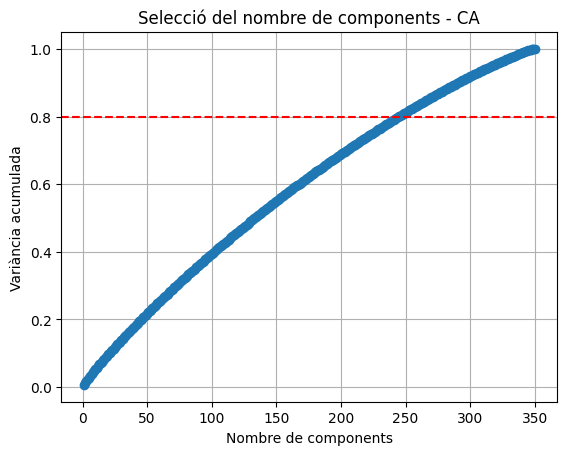

In [20]:
import prince

X = tfidf_df.drop("Name", axis=1).values

ca = prince.CA(n_components=min(X.shape))
ca = ca.fit(tfidf_df.drop("Name", axis=1))

import numpy as np
import matplotlib.pyplot as plt

eigenvalues = ca.eigenvalues_
inertia_explicada = eigenvalues / sum(eigenvalues)
inertia_cumulada = np.cumsum(inertia_explicada)

llindar = 0.80
num_components = np.argmax(inertia_cumulada >= llindar) + 1
print(f"Nombre òptim de components per explicar {llindar*100}% de variància: {num_components}")

plt.plot(range(1, len(inertia_cumulada)+1), inertia_cumulada, marker='o')
plt.axhline(y=llindar, color='r', linestyle='--')
plt.xlabel('Nombre de components')
plt.ylabel('Variància acumulada')
plt.title('Selecció del nombre de components - CA')
plt.grid(True)
plt.savefig('imatges/acm.png')
plt.show()

Nombre òptim de components per explicar 80.0% de variància: 230


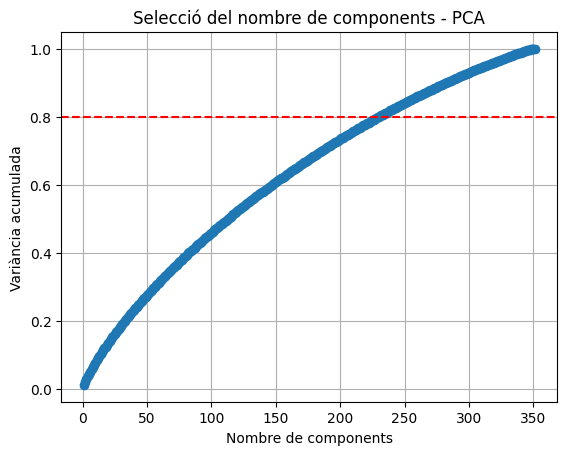

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Suposem que tens tfidf_df sense la columna 'Name'
X = tfidf_df.drop("Name", axis=1).values

# Crear PCA amb nombre màxim de components
pca = PCA(n_components=min(X.shape))  # nombre màxim possible (files o columnes)

# Ajustar el model
pca.fit(X)

# Variància explicada per component
var_exp = pca.explained_variance_ratio_

# Variància acumulada
var_exp_cum = np.cumsum(var_exp)

# Mostrar variància acumulada i triar components que expliquin 85%
llindar = 0.80
num_components = np.argmax(var_exp_cum >= llindar) + 1
print(f"Nombre òptim de components per explicar {llindar*100}% de variància: {num_components}")

# Visualitzar la corba de variància acumulada
plt.plot(range(1, len(var_exp_cum)+1), var_exp_cum, marker='o')
plt.axhline(y=llindar, color='r', linestyle='--')
plt.xlabel('Nombre de components')
plt.ylabel('Variància acumulada')
plt.title('Selecció del nombre de components - PCA')
plt.grid(True)
plt.savefig('imatges/pca.png')
plt.show()

# Transformar les dades segons els components seleccionats
pca_final = PCA(n_components=num_components)
X_pca = pca_final.fit_transform(X)

# Ara tens X_pca amb la representació reduïda


En aplicar l’ACM i el PCA, observem que la variància acumulada creix de manera gairebé lineal, sense un punt de colze clar. Això indica que cada nova dimensió aporta un percentatge similar d’informació respecte a l’anterior, de manera que no té gaire sentit reduir dimensionalitat, ja que no hi ha components clarament dominants.